Modified LinUCBAgent class from day1 to also contain thompson sampling algo as the update mech is the same for both TS and LinUCB 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class LinearBanditAgent:
    def __init__(self, d, alpha=1.0, lambda_reg=1.0, mode='UCB', R=1.0):
        """
        d: context dimension
        alpha: exploration parameter (for UCB) or not used (for TS)
        lambda_reg: regularization parameter
        mode: 'UCB' or 'TS'
        R: reward variance parameter for TS (variance inflation factor)
        """
        self.d = d
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.mode = mode
        self.R = R  # Variance inflation factor for Thompson Sampling

        # Initialize using Bayesian linear regression setup
        # Prior: theta ~ N(0, lambda_reg^(-1) * I)
        # Posterior covariance: inv_G (updated via Sherman-Morrison)
        self.theta_hat = np.zeros(d, dtype=np.float64)
        self.inv_G = (1.0 / lambda_reg) * np.eye(d, dtype=np.float64)
        self.S = np.zeros(d, dtype=np.float64)  # S = sum of rewards * actions

    def select(self, action_set_t):
        """
        action_set_t: matrix of shape (K, d) where each row is an action context
        """
        if self.mode == 'UCB':
            # LinUCB: mean + alpha * uncertainty
            mean = action_set_t @ self.theta_hat
            uncertainty = np.sqrt(np.sum((action_set_t @ self.inv_G) * action_set_t, axis=1))
            scores = mean + self.alpha * uncertainty
            
        elif self.mode == 'TS':
            # Thompson Sampling: Sample from posterior distribution
            # Posterior: theta ~ N(theta_hat, R^2 * inv_G)
            # For proper Bayesian linear regression with Gaussian prior/posterior
            try:
                # Sample theta_tilde from posterior
                # Covariance matrix: R^2 * inv_G
                covariance = (self.R ** 2) * self.inv_G
                theta_tilde = np.random.multivariate_normal(self.theta_hat, covariance)
            except np.linalg.LinAlgError:
                # If covariance is singular, use regularized version
                covariance = (self.R ** 2) * self.inv_G + 1e-6 * np.eye(self.d)
                theta_tilde = np.random.multivariate_normal(self.theta_hat, covariance)
            
            # Compute expected reward for each action
            scores = action_set_t @ theta_tilde
            
        return np.argmax(scores)

    def update_all(self, a, reward):
        """
        Update posterior distribution with observed (action, reward) pair.
        Uses Sherman-Morrison formula for efficient update.
        """
        # Sherman-Morrison Update for inv_G (posterior covariance)
        v = self.inv_G @ a
        numerator = np.outer(v, v)
        denominator = 1.0 + np.dot(a, v)
        
        # Update inv_G (inverse of posterior covariance)
        self.inv_G -= numerator / denominator
        
        # Update S (sum of rewards * actions)
        self.S += reward * a
        
        # Update theta_hat (posterior mean)
        self.theta_hat = self.inv_G @ self.S

In [10]:
def test_with_delay(d=3, K=4, T=500, delay=100, alpha=1.0, lambda_reg=1.0, 
                    noise_std=0.1, R=1.0, seed=42):
    """
    Test LinUCB vs Thompson Sampling with delayed rewards.
    
    Args:
        delay: number of time steps before reward is observed (default 100)
    """
    np.random.seed(seed)
    
    # True theta (unknown to agents)
    true_theta = np.array([0.5, -0.3, 0.8])[:d]
    
    # Initialize agents
    agent_linucb = LinearBanditAgent(d=d, alpha=alpha, lambda_reg=lambda_reg, mode='UCB')
    agent_ts = LinearBanditAgent(d=d, alpha=alpha, lambda_reg=lambda_reg, mode='TS', R=R)
    
    # Generate action set (fixed across time)
    action_set = np.random.randn(K, d)
    action_set = action_set / np.linalg.norm(action_set, axis=1, keepdims=True)
    
    # Delay queues: store (action, reward) pairs that will be processed later
    delay_queue_linucb = []
    delay_queue_ts = []
    
    # Storage for results
    cumulative_regret_linucb = []
    cumulative_regret_ts = []
    total_regret_linucb = 0.0
    total_regret_ts = 0.0
    
    print(f"Testing with {delay}-step delay")
    print(f"True theta: {true_theta}\n")
    
    for t in range(T):
        # Select arms
        arm_idx_linucb = agent_linucb.select(action_set)
        arm_idx_ts = agent_ts.select(action_set)
        
        # Get features and compute rewards
        arm_features_linucb = action_set[arm_idx_linucb]
        arm_features_ts = action_set[arm_idx_ts]
        
        true_reward_linucb = np.dot(arm_features_linucb, true_theta)
        true_reward_ts = np.dot(arm_features_ts, true_theta)
        
        observed_reward_linucb = true_reward_linucb + np.random.normal(0, noise_std)
        observed_reward_ts = true_reward_ts + np.random.normal(0, noise_std)
        
        # Add to delay queue (will be processed after 'delay' steps)
        delay_queue_linucb.append((arm_features_linucb.copy(), observed_reward_linucb))
        delay_queue_ts.append((arm_features_ts.copy(), observed_reward_ts))
        
        # Compute regret (using true optimal arm)
        best_reward = max([np.dot(action_set[i], true_theta) for i in range(K)])
        
        regret_linucb = best_reward - true_reward_linucb
        total_regret_linucb += regret_linucb
        cumulative_regret_linucb.append(total_regret_linucb)
        
        regret_ts = best_reward - true_reward_ts
        total_regret_ts += regret_ts
        cumulative_regret_ts.append(total_regret_ts)
        
        # Process delayed rewards (if any)
        if t >= delay:
            # Get reward from 'delay' steps ago
            a_delayed_linucb, r_delayed_linucb = delay_queue_linucb[t - delay]
            a_delayed_ts, r_delayed_ts = delay_queue_ts[t - delay]
            
            # Update agents with delayed rewards
            agent_linucb.update_all(a_delayed_linucb, r_delayed_linucb)
            agent_ts.update_all(a_delayed_ts, r_delayed_ts)
    
    # Print final results
    print("=" * 60)
    print("FINAL RESULTS:")
    print("=" * 60)
    print(f"\nLinUCB:")
    print(f"  Total regret: {total_regret_linucb:.2f}")
    print(f"  Final theta_hat: {agent_linucb.theta_hat}")
    
    print(f"\nThompson Sampling:")
    print(f"  Total regret: {total_regret_ts:.2f}")
    print(f"  Final theta_hat: {agent_ts.theta_hat}")
    
    print(f"\nTrue theta: {true_theta}")
    
    return {
        'ucb_regret': cumulative_regret_linucb,
        'ts_regret': cumulative_regret_ts,
        'ucb_final': total_regret_linucb,
        'ts_final': total_regret_ts,
        'true_theta': true_theta
    }
    

In [11]:
# Run comparison: LinUCB vs Thompson Sampling with 100-step delay
results_delayed = test_with_delay(d=3, K=4, T=1000, delay=100, alpha=1.0, 
                                  lambda_reg=1.0, noise_std=0.1, R=1.0, seed=42)

Testing with 100-step delay
True theta: [ 0.5 -0.3  0.8]

FINAL RESULTS:

LinUCB:
  Total regret: 56.81
  Final theta_hat: [ 0.52217139 -0.15666802  0.81326805]

Thompson Sampling:
  Total regret: 62.18
  Final theta_hat: [ 0.51716    -0.27655995  0.78622635]

True theta: [ 0.5 -0.3  0.8]


In [12]:
# Compare with NO delay to see impact of delay
results_immediate = test_with_delay(d=3, K=4, T=1000, delay=0, alpha=1.0, 
                                    lambda_reg=1.0, noise_std=0.1, R=1.0, seed=42)

Testing with 0-step delay
True theta: [ 0.5 -0.3  0.8]

FINAL RESULTS:

LinUCB:
  Total regret: 1.13
  Final theta_hat: [ 0.54136034 -0.1585143   0.79740581]

Thompson Sampling:
  Total regret: 18.83
  Final theta_hat: [ 0.51380557 -0.2908904   0.78751471]

True theta: [ 0.5 -0.3  0.8]


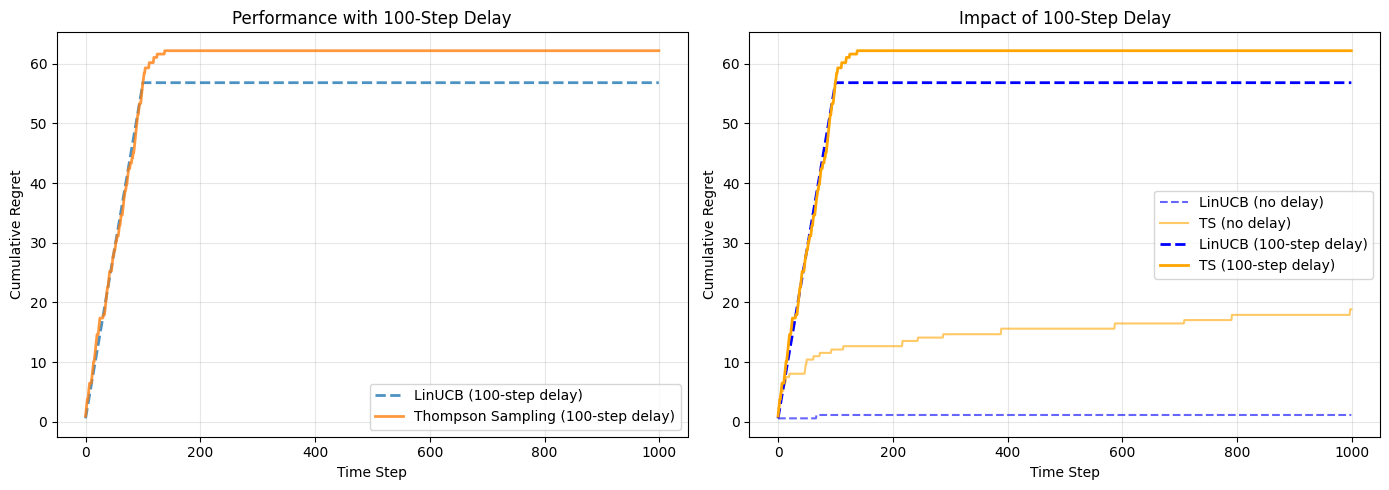


COMPARISON: Impact of 100-Step Delay

Metric                         No Delay             100-Step Delay       Degradation    
----------------------------------------------------------------------
LinUCB Final Regret            1.13                 56.81                    4950.0%
TS Final Regret                18.83                62.18                     230.1%

Analysis:
  LinUCB degradation: 4950.0%
  TS degradation: 230.1%


In [14]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Regret over time (with delay)
ax1 = axes[0]
ax1.plot(results_delayed['ucb_regret'], label='LinUCB (100-step delay)', 
         linewidth=2, linestyle='--', alpha=0.8)
ax1.plot(results_delayed['ts_regret'], label='Thompson Sampling (100-step delay)', 
         linewidth=2, alpha=0.8)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Regret')
ax1.set_title('Performance with 100-Step Delay')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Comparison with and without delay
ax2 = axes[1]
ax2.plot(results_immediate['ucb_regret'], label='LinUCB (no delay)', 
         linewidth=1.5, linestyle='--', alpha=0.6, color='blue')
ax2.plot(results_immediate['ts_regret'], label='TS (no delay)', 
         linewidth=1.5, alpha=0.6, color='orange')
ax2.plot(results_delayed['ucb_regret'], label='LinUCB (100-step delay)', 
         linewidth=2, linestyle='--', color='blue')
ax2.plot(results_delayed['ts_regret'], label='TS (100-step delay)', 
         linewidth=2, color='orange')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Cumulative Regret')
ax2.set_title('Impact of 100-Step Delay')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("COMPARISON: Impact of 100-Step Delay")
print("=" * 70)
print(f"\n{'Metric':<30} {'No Delay':<20} {'100-Step Delay':<20} {'Degradation':<15}")
print("-" * 70)
print(f"{'LinUCB Final Regret':<30} {results_immediate['ucb_final']:<20.2f} "
      f"{results_delayed['ucb_final']:<20.2f} "
      f"{((results_delayed['ucb_final'] / results_immediate['ucb_final'] - 1) * 100):>10.1f}%")
print(f"{'TS Final Regret':<30} {results_immediate['ts_final']:<20.2f} "
      f"{results_delayed['ts_final']:<20.2f} "
      f"{((results_delayed['ts_final'] / results_immediate['ts_final'] - 1) * 100):>10.1f}%")
print("=" * 70)

# Analysis
ucb_degradation = (results_delayed['ucb_final'] / results_immediate['ucb_final'] - 1) * 100
ts_degradation = (results_delayed['ts_final'] / results_immediate['ts_final'] - 1) * 100

print(f"\nAnalysis:")
print(f"  LinUCB degradation: {ucb_degradation:.1f}%")
print(f"  TS degradation: {ts_degradation:.1f}%")